# Read Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report

import warnings
warnings.filterwarnings('ignore')

In [5]:
train_dir = r'D:\MO CODE\project NN\Nueral Project\train'
test_dir = r'D:\MO CODE\project NN\Nueral Project\test'


In [6]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 20
CLASS_LABELS  = ['NORMAL', 'PNEUMONIA']
NUM_CLASSES = 2

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical' 
)

validation_generator = test_datagen.flow_from_directory(
    directory=test_dir,  
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical' 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=False
)



Found 148 images belonging to 2 classes.


Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# Build Model CNN

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

In [9]:
def create_model(dropout_rate):
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(dropout_rate))  # Use the current dropout rate

    # Third convolutional block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(dropout_rate))  # Use the current dropout rate

    # Fourth convolutional block
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout_rate))  # Use the current dropout rate
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(dropout_rate))  # Use the current dropout rate
    model.add(Dense(units=32, activation='relu'))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Fine Tuning

In [ ]:
# Define hyperparameter grid manually
batch_sizes = [16, 32, 64]
epochs_list = [10, 20]
dropout_rates = [0.0, 0.2, 0.5]

best_val_acc = 0
best_params = {}

# Iterate over hyperparameters
for batch_size in batch_sizes:
    for epochs in epochs_list:
        for dropout_rate in dropout_rates:
            print(f"Training with batch_size={batch_size}, epochs={epochs}, dropout_rate={dropout_rate}")
            
            # Create a new model
            model = create_model(dropout_rate=dropout_rate)
            
            # Train the model
            history = model.fit(
                train_generator,
                validation_data=validation_generator,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0  # Suppress detailed output
            )
            
            # Get validation accuracy
            val_acc = history.history['val_accuracy'][-1]
            print(f"Validation Accuracy: {val_acc}")
            
            # Update best parameters
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'dropout_rate': dropout_rate
                }
                
print(f"Best Validation Accuracy: {best_val_acc}")
print(f"Best Parameters: {best_params}")


Training with batch_size=16, epochs=10, dropout_rate=0.0
Validation Accuracy: 0.949999988079071
Training with batch_size=16, epochs=10, dropout_rate=0.2
Validation Accuracy: 0.949999988079071
Training with batch_size=16, epochs=10, dropout_rate=0.5
Validation Accuracy: 0.75
Training with batch_size=16, epochs=20, dropout_rate=0.0
Validation Accuracy: 0.8500000238418579
Training with batch_size=16, epochs=20, dropout_rate=0.2
Validation Accuracy: 0.9750000238418579
Training with batch_size=16, epochs=20, dropout_rate=0.5
Validation Accuracy: 0.5
Training with batch_size=32, epochs=10, dropout_rate=0.0
Validation Accuracy: 0.949999988079071
Training with batch_size=32, epochs=10, dropout_rate=0.2
Validation Accuracy: 0.9750000238418579
Training with batch_size=32, epochs=10, dropout_rate=0.5
Validation Accuracy: 0.5
Training with batch_size=32, epochs=20, dropout_rate=0.0
Validation Accuracy: 0.9750000238418579
Training with batch_size=32, epochs=20, dropout_rate=0.2
Validation Accuracy:

In [110]:
acc=model.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step - accuracy: 0.5000 - loss: 0.6923


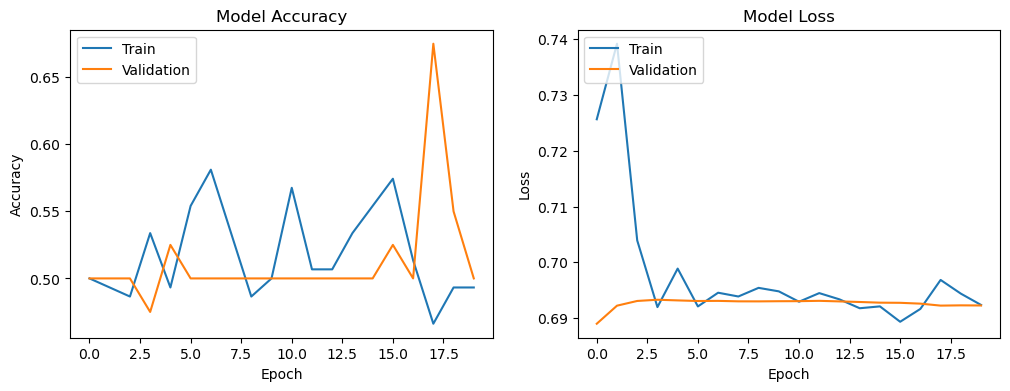

In [12]:
# Plot accuracy and loss graphs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


# Plot the training history
plot_training_history(history)


# Transfomer Traning VGG16 Model

In [13]:
from keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

In [14]:
# Load the pre-trained VGG16 model without the top classification layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the VGG16 base layers (these won't be trained)
vgg_base.trainable = False

# Build Model VGG16

In [15]:
# Build the Sequential model
model2 = Sequential()

# Add the pre-trained VGG16 base model | extract features only
model2.add(vgg_base)

# Add a pooling layer to reduce the output from the VGG model (either Flatten or GlobalAveragePooling)
model2.add(GlobalAveragePooling2D()) ## GlobalAveragePooling2D = CNN  |  Flatten

# Add Dense layers on top for the new classification task
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(units=64, activation='relu'))

# Output layer for 7 classes (adjust the number based on your dataset)
model2.add(Dense(units=2, activation='softmax'))

# Compile VGG16

In [16]:
# Compile the model
model2.compile(optimizer=Adam(), loss='BinaryCrossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(
    x=train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5723 - loss: 0.7166 - val_accuracy: 0.6250 - val_loss: 0.6327
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6382 - loss: 0.6633 - val_accuracy: 0.7000 - val_loss: 0.5858
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6772 - loss: 0.6088 - val_accuracy: 0.9000 - val_loss: 0.4959
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7719 - loss: 0.5402 - val_accuracy: 1.0000 - val_loss: 0.4282
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7807 - loss: 0.5522 - val_accuracy: 1.0000 - val_loss: 0.3839
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7898 - loss: 0.4980 - val_accuracy: 0.9750 - val_loss: 0.3411
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8868 - loss: 0.4280 - val_accuracy: 0.9500 - val_loss: 0.3115
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8726 - loss: 0.4099 - val_accuracy: 0.9750 - val_loss: 0.2751
Epoch 9/20
3/3 ━

In [111]:
acc2=model2.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step - accuracy: 0.9500 - loss: 0.1196


# Data drawing VGG16

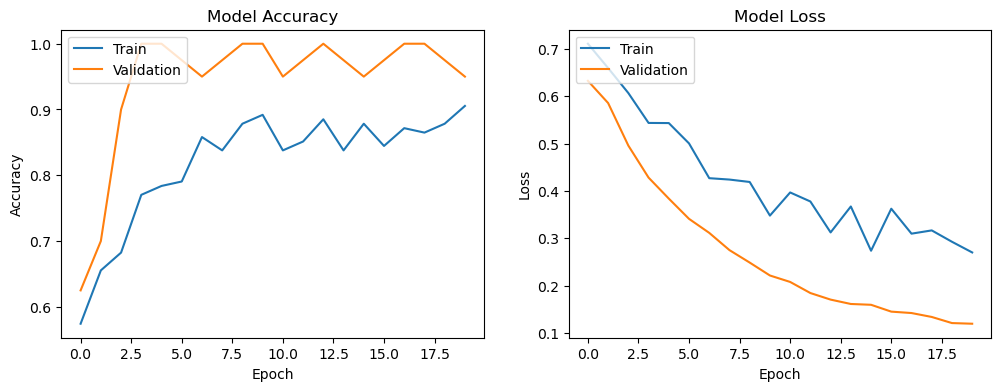

In [19]:
# Plot training accuracy and loss
plot_training_history(history2)

# Save Model

In [20]:
# Save the model
model.save(r'D:\MO CODE\project NN\Nueral Project\model\my_model.h5')


In [114]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, img_height, img_width):
    img = load_img(image_path, target_size=(img_height, img_width))  
    img_array = img_to_array(img) 
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array

def predict_image(model, image_path, img_height, img_width, class_labels):
    preprocessed_image = preprocess_image(image_path, img_height, img_width)
    prediction = model.predict(preprocessed_image)  
    predicted_class = class_labels[np.argmax(prediction)]  
    return predicted_class

image_path = r"D:\MO CODE\project NN\Nueral Project\test\PNEUMONIA\ryct.2020200034.fig5-day4.jpeg"
class_labels = ['NORMAL', 'PNEUMONIA']  

predicted_class = predict_image(model2, image_path, IMG_HEIGHT, IMG_WIDTH, class_labels)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Class: PNEUMONIA
